<a href="https://colab.research.google.com/github/claudio-iturra/colab.research/blob/main/modis_oc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Evaluating river plume intensity from the @itata and @biobio rivers in central–southern Chile
# Claudio Iturra, 2025
# practico #12
# envio de informes claudio-iturra@ace.me, dead-line monday 23:59:00 (UTC)
# oc files = https://drive.google.com/drive/folders/1xer-SZzSYDvMOtV2OYkvA5ghedZioFio?usp=drive_link

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_mask(var):
    data = var[:]                 # usually masked array
    fv = getattr(var, "_FillValue", None)
    if fv is not None:
        data = np.ma.masked_equal(data, fv)
    # mask negatives / zeros
    data = np.ma.masked_less_equal(data, 0)
    return data

In [ ]:
def stretch_band(x, pmin=0.1, pmax=99.9, gamma=0.45, gain=1.0):
    # use only valid data
    if np.ma.isMaskedArray(x):
        data = x.compressed()
    else:
        data = x[np.isfinite(x)]

    if data.size < 10:
        return np.zeros_like(x, dtype=float)

    vmin, vmax = np.percentile(data, [pmin, pmax])
    # force a sensible range for Rrs
    vmin = max(vmin, 0.0)
    vmax = max(vmax, vmin + 1e-4)

    y = (x - vmin) / (vmax - vmin)
    y = np.clip(y, 0, 1)

    # gamma < 1 brightens mid-tones; gain boosts the band
    y = (y ** (1.0 / gamma)) * gain
    y = np.clip(y, 0, 1)

    if np.ma.isMaskedArray(y):
        y = y.filled(0)
    return y

In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.0 MB/s eta 0:00:00


In [ ]:
from netCDF4 import Dataset

In [ ]:
cd/content/drive/MyDrive/downloads

/content/drive/MyDrive/downloads


In [ ]:
ls -l

total 12680
-rw------- 1 root root 1091551 Nov 21 15:57 AQUA_MODIS.20020830T185001.L2.OC.x.nc
-rw------- 1 root root 1071183 Nov 21 15:57 AQUA_MODIS.20030716T185001.L2.OC.x.nc
-rw------- 1 root root 1082308 Nov 21 15:58 AQUA_MODIS.20051025T185001.L2.OC.x.nc
-rw------- 1 root root 1100593 Nov 21 16:02 AQUA_MODIS.20060926T185001.L2.OC.x.nc
-rw------- 1 root root 1073584 Nov 21 16:05 AQUA_MODIS.20061129T185002.L2.OC.x.nc
-rw------- 1 root root 1070291 Nov 21 16:05 AQUA_MODIS.20070727T185001.L2.OC.x.nc
-rw------- 1 root root 1084045 Nov 21 16:08 AQUA_MODIS.20081017T185500.L2.OC.x.nc
-rw------- 1 root root 1079756 Nov 21 16:15 AQUA_MODIS.20110814T190001.L2.OC.x.nc
-rw------- 1 root root 1075193 Nov 21 15:59 AQUA_MODIS.20171026T185000.L2.OC.x.nc
-rw------- 1 root root 1083500 Nov 21 16:08 AQUA_MODIS.20190829T185000.L2.OC.x.nc
-rw------- 1 root root 1092413 Nov 21 16:12 AQUA_MODIS.20201018T185000.L2.OC.x.nc
-rw------- 1 root root 1077516 Nov 21 16:13 AQUA_MODIS.20210311T185000.L2.OC.x.nc


In [ ]:
from pathlib import Path
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
data_dir = Path("/content/drive/MyDrive/downloads/")   # e.g. Path(".") for current folder
nc_files = sorted(data_dir.glob("*.nc"))

In [ ]:
nc_files[0]

PosixPath('/content/drive/MyDrive/downloads/AQUA_MODIS.20020830T185001.L2.OC.x.nc')

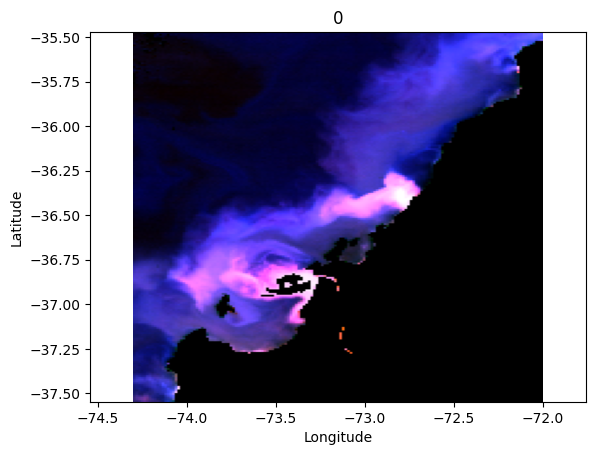

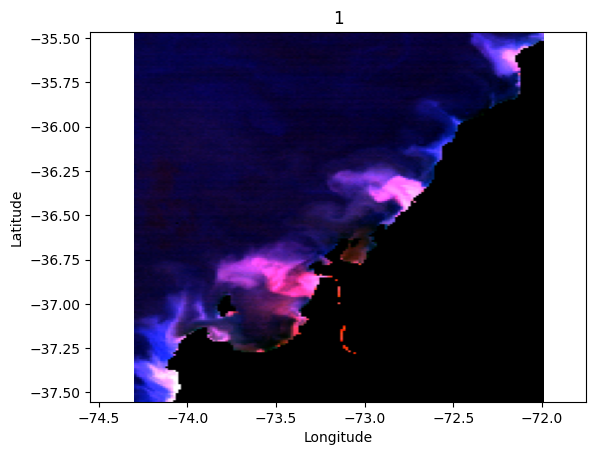

In [ ]:
#from matplotlib import pyplot
#pyplot.rcParams['figure.dpi'] = 300
#pyplot.rcParams['savefig.dpi'] = 300

for i in range(0,2): # first 2 files.
    nc  = Dataset(nc_files[i], "r")
    nav = nc.groups["navigation_data"]
    geo = nc.groups["geophysical_data"]

    lat = nav["latitude"][:]
    lon = nav["longitude"][:]

    # --- RGB bands (Rrs) ---
    R = read_mask(geo["Rrs_645"])
    G = read_mask(geo["Rrs_547"])
    B = read_mask(geo["Rrs_469"])

    # ---------- 1) ORIENTATION FIX (same logic as before) ----------
    R2, G2, B2 = R.copy(), G.copy(), B.copy()
    lat2, lon2 = lat.copy(), lon.copy()

    if np.nanmean(lat2[0, :]) < np.nanmean(lat2[-1, :]):
        lat2 = np.flip(lat2, axis=0)
        lon2 = np.flip(lon2, axis=0)
        R2   = np.flip(R2,   axis=0)
        G2   = np.flip(G2,   axis=0)
        B2   = np.flip(B2,   axis=0)

    if np.nanmean(lon2[:, 0]) > np.nanmean(lon2[:, -1]):
        lat2 = np.flip(lat2, axis=1)
        lon2 = np.flip(lon2, axis=1)
        R2   = np.flip(R2,   axis=1)
        G2   = np.flip(G2,   axis=1)
        B2   = np.flip(B2,   axis=1)

    R_s = stretch_band(R2, gamma=0.8, gain=5)
    G_s = stretch_band(G2, gamma=0.8, gain=1)
    B_s = stretch_band(B2, gamma=0.8, gain=3)

    rgb = np.dstack([R_s, G_s, B_s])

    extent = [np.nanmin(lon2), np.nanmax(lon2),
              np.nanmin(lat2), np.nanmax(lat2)]

    plt.figure()
    plt.imshow(rgb, origin="upper", extent=extent)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(i)
    plt.axis('equal')
    #plt.grid()

    del nc, nav, geo, lon, lat, R, G, B

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 95.7 MB/s eta 0:00:00


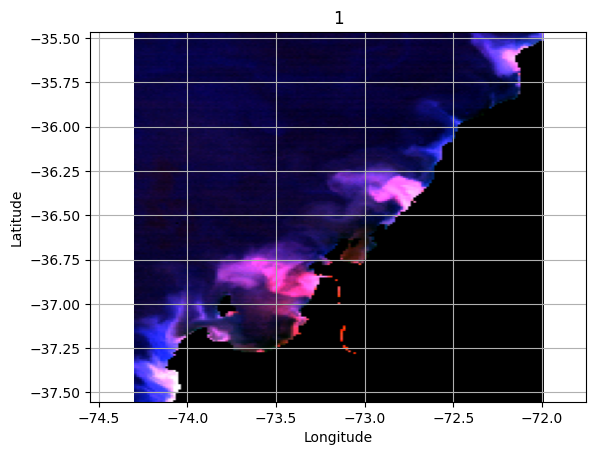

In [ ]:
#from matplotlib import pyplot
#pyplot.rcParams['figure.dpi'] = 300
#pyplot.rcParams['savefig.dpi'] = 300

nc  = Dataset(nc_files[1], "r")
nav = nc.groups["navigation_data"]
geo = nc.groups["geophysical_data"]
lat = nav["latitude"][:]
lon = nav["longitude"][:]

# --- RGB bands (Rrs) ---
R = read_mask(geo["Rrs_645"])
G = read_mask(geo["Rrs_547"])
B = read_mask(geo["Rrs_469"])

# ---------- 1) ORIENTATION FIX (same logic as before) ----------
R2, G2, B2 = R.copy(), G.copy(), B.copy()
lat2, lon2 = lat.copy(), lon.copy()

if np.nanmean(lat2[0, :]) < np.nanmean(lat2[-1, :]):
  lat2 = np.flip(lat2, axis=0)
  lon2 = np.flip(lon2, axis=0)
  R2   = np.flip(R2,   axis=0)
  G2   = np.flip(G2,   axis=0)
  B2   = np.flip(B2,   axis=0)

if np.nanmean(lon2[:, 0]) > np.nanmean(lon2[:, -1]):
  lat2 = np.flip(lat2, axis=1)
  lon2 = np.flip(lon2, axis=1)
  R2   = np.flip(R2,   axis=1)
  G2   = np.flip(G2,   axis=1)
  B2   = np.flip(B2,   axis=1)

  R_s = stretch_band(R2, gamma=0.8, gain=5)
  G_s = stretch_band(G2, gamma=0.8, gain=1)
  B_s = stretch_band(B2, gamma=0.8, gain=3)

  rgb = np.dstack([R_s, G_s, B_s])

  extent = [np.nanmin(lon2), np.nanmax(lon2),
            np.nanmin(lat2), np.nanmax(lat2)]


plt.imshow(rgb, origin="upper", extent=extent)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(i)
plt.axis('equal')
plt.grid()

del nc, nav, geo, lon, lat, R, G, B

In [ ]:
# fixing coordinates system

/tmp/ipython-input-1426429054.py:76: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(lon2, lat2, np.log10(R_s), shading='auto', cmap = 'turbo')


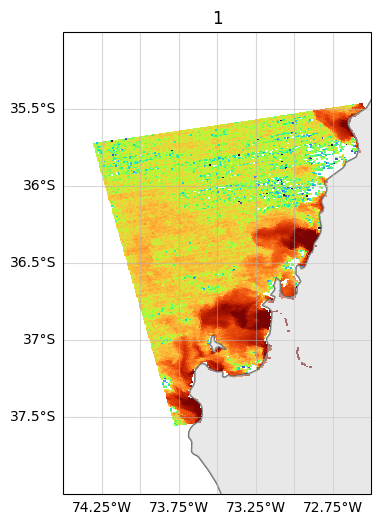

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

nc  = Dataset(nc_files[1], "r")
nav = nc.groups["navigation_data"]
geo = nc.groups["geophysical_data"]
lat = nav["latitude"][:]   # likely 2D
lon = nav["longitude"][:]

# --- RGB bands (Rrs) ---
R = read_mask(geo["Rrs_645"])
G = read_mask(geo["Rrs_547"])
B = read_mask(geo["Rrs_469"])

# Make copies to operate on
R2, G2, B2 = R.copy(), G.copy(), B.copy()
lat2, lon2 = lat.copy(), lon.copy()

# 1) Ensure latitude is increasing from bottom->top
if np.nanmean(lat2[0, :]) < np.nanmean(lat2[-1, :]):
    lat2 = np.flip(lat2, axis=0)
    lon2 = np.flip(lon2, axis=0)
    R2   = np.flip(R2,   axis=0)
    G2   = np.flip(G2,   axis=0)
    B2   = np.flip(B2,   axis=0)

# 2) Ensure longitude increases left->right (simple check for typical swath)
if np.nanmean(lon2[:, 0]) > np.nanmean(lon2[:, -1]):
    lat2 = np.flip(lat2, axis=1)
    lon2 = np.flip(lon2, axis=1)
    R2   = np.flip(R2,   axis=1)
    G2   = np.flip(G2,   axis=1)
    B2   = np.flip(B2,   axis=1)

# 3) Fix longitude wrap (convert 0..360 -> -180..180)
# Only apply if lon appears to be in 0..360
if np.nanmin(lon2) >= 0 and np.nanmax(lon2) > 180:
    lon2 = ((lon2 + 180) % 360) - 180

# 4) Stretch / scale bands and build rgb (ensure this always runs)
R_s = stretch_band(R2, gamma=0.8, gain=1)
G_s = stretch_band(G2, gamma=0.8, gain=1)
B_s = stretch_band(B2, gamma=0.8, gain=1)

# Ensure rgb in 0..1 and NaNs handled
rgb = np.dstack([R_s, G_s, B_s])
rgb = np.nan_to_num(rgb)            # replace NaN with 0
rgb = np.clip(rgb, 0.0, 1.0)        # ensure valid range for imshow

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-74.5, -72.5, -38, -35], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.5, zorder = 7)
#ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)

# Add gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.top_labels = False
gl.right_labels = False


# 5a) If lon/lat are 1D regular grid -> use extent
if lon2.ndim == 1 and lat2.ndim == 1:
    extent = [np.nanmin(lon2), np.nanmax(lon2),
              np.nanmin(lat2), np.nanmax(lat2)]
    plt.imshow(rgb, origin="lower", extent=extent, aspect='equal')
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.title(i)
    plt.grid()
else:
    # 5b) If lon/lat are 2D (swath) -> use pcolormesh for geolocation accuracy
    #fig, ax = plt.subplots(figsize=(8,6))
    # use the red band as an example for background / shading
    ax.pcolormesh(lon2, lat2, np.log10(R_s), shading='auto', cmap = 'turbo')
    # overlay RGB using imshow is tricky for irregular grids;
    # instead save RGB to geotiff or regrid to a regular lon/lat before imshow,
    # or scatter a subset of points:
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    ax.set_title(i)
    ax.set_aspect('equal', adjustable='box')
    plt.show()

# cleanup
del nc, nav, geo, lon, lat, R, G, B


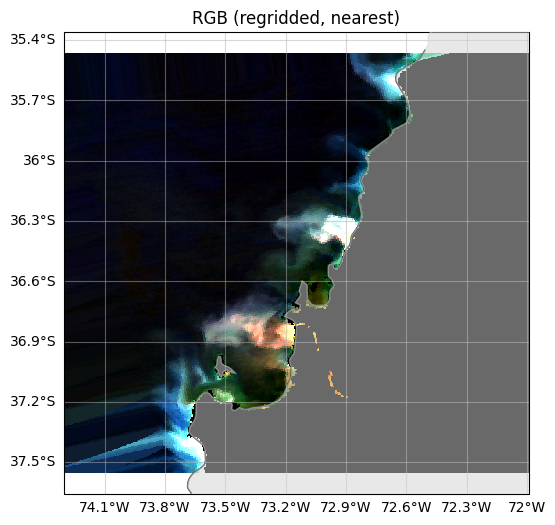

In [ ]:
from matplotlib import pyplot
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['savefig.dpi'] = 100

from scipy.interpolate import griddata

# flatten swath points
points = np.column_stack((lon2.ravel(), lat2.ravel()))
Rf = R_s.ravel(); Gf = G_s.ravel(); Bf = B_s.ravel()

# define regular target grid (choose resolution)
lon_min, lon_max = np.nanmin(lon2), np.nanmax(lon2)
lat_min, lat_max = np.nanmin(lat2), np.nanmax(lat2)
nx, ny = 800, 600   # tweak for desired resolution
grid_lon = np.linspace(lon_min, lon_max, nx)
grid_lat = np.linspace(lat_min, lat_max, ny)
grid_lon2, grid_lat2 = np.meshgrid(grid_lon, grid_lat)

# nearest regrid to preserve color edges
Rg = griddata(points, Rf, (grid_lon2, grid_lat2), method='nearest')
Gg = griddata(points, Gf, (grid_lon2, grid_lat2), method='nearest')
Bg = griddata(points, Bf, (grid_lon2, grid_lat2), method='nearest')

rgb_grid = np.dstack([Rg, Gg, Bg])

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-74.5, -72.5, -38, -35], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.5, zorder = 7)
#ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)

# Add gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.top_labels = False
gl.right_labels = False
plt.imshow(rgb_grid, origin='lower',
           extent=[lon_min, lon_max, lat_min, lat_max],
           interpolation='nearest')
plt.xlabel("Longitude"); plt.ylabel("Latitude"); plt.title("RGB (regridded, nearest)")
plt.axis('equal')
plt.show()
